In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
import joblib

In [2]:
df = pd.read_csv('/kaggle/input/nyc-motor-vehicle-collisions/Motor_Vehicle_Collisions_-_Crashes.csv', parse_dates=['CRASH DATE'], low_memory=False)
df = df[~(df['BOROUGH'].isna() & (df['LATITUDE'].isna() | df['LONGITUDE'].isna()))]
n_days = 30  # days to forecast
len(df)

1965672

In [3]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df = df.dropna(subset=['CRASH DATE', 'BOROUGH'])

daily = df.groupby('CRASH DATE').size().reset_index(name='y')
daily = daily.set_index('CRASH DATE').asfreq('D').fillna(0)

In [4]:
model = SARIMAX(
    daily['y'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),  # Weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = model.fit(disp=False)


In [5]:
n_days = 30
future_dates = pd.date_range(start=daily.index[-1] + timedelta(days=1), periods=n_days, freq='D')

forecast = sarima_result.get_forecast(steps=n_days)
forecast_df = forecast.summary_frame()
forecast_df['ds'] = future_dates
forecast_df.rename(columns={'mean': 'yhat'}, inplace=True)


In [6]:
recent = df[df['CRASH DATE'] >= daily.index[-30]]
borough_share = recent['BOROUGH'].value_counts(normalize=True)

borough_forecasts = []
for borough, share in borough_share.items():
    borough_forecast = forecast_df[['ds', 'yhat']].copy()
    borough_forecast['yhat'] *= share
    borough_forecast['BOROUGH'] = borough
    borough_forecasts.append(borough_forecast)

borough_forecast_df = pd.concat(borough_forecasts)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

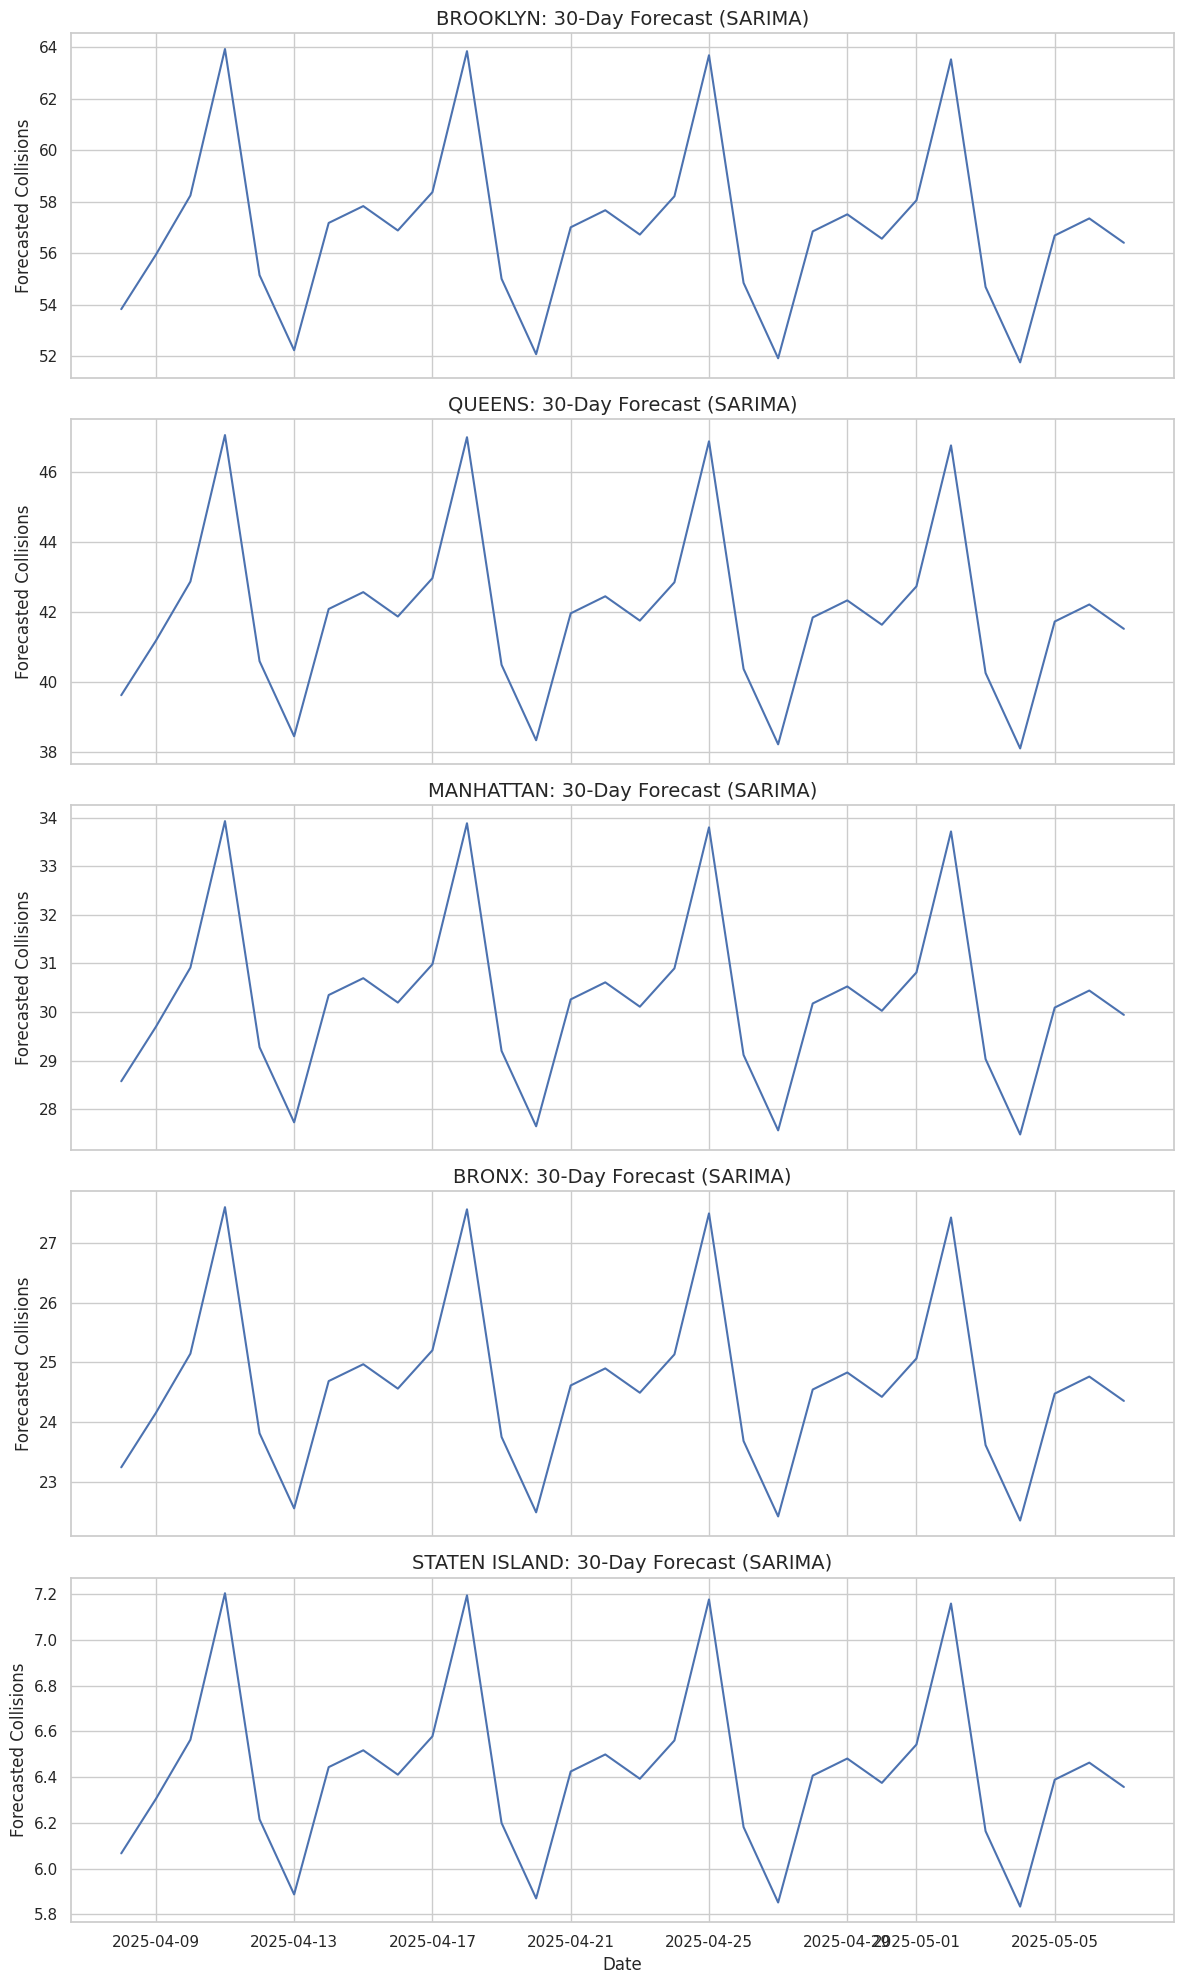

In [7]:
sns.set(style="whitegrid")
boroughs = borough_forecast_df['BOROUGH'].unique()
n_boroughs = len(boroughs)

fig, axes = plt.subplots(n_boroughs, 1, figsize=(12, 4 * n_boroughs), sharex=True)

if n_boroughs == 1:
    axes = [axes]

for ax, borough in zip(axes, boroughs):
    df_b = borough_forecast_df[borough_forecast_df['BOROUGH'] == borough]
    sns.lineplot(data=df_b, x='ds', y='yhat', ax=ax)
    ax.set_title(f'{borough}: 30-Day Forecast (SARIMA)', fontsize=14)
    ax.set_ylabel("Forecasted Collisions")
    ax.set_xlabel("Date")

plt.tight_layout()
plt.show()


In [8]:
import joblib
joblib.dump(sarima_result, 'sarima_city_model.pkl')


['sarima_city_model.pkl']

In [9]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Step 1: Define evaluation period
eval_days = 30
eval_start = daily.index[-eval_days]

# Step 2: Get predictions for last 30 actual days
pred = sarima_result.get_prediction(start=eval_start, end=daily.index[-1])
pred_df = pred.summary_frame()
pred_df['ds'] = pred_df.index
pred_df.rename(columns={'mean': 'yhat'}, inplace=True)

# Step 3: Merge with actuals
actual = daily.reset_index().rename(columns={'CRASH DATE': 'ds'})
eval_df = actual.merge(pred_df[['ds', 'yhat']], on='ds', how='inner')

# Step 4: Compute metrics
mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
mape = mean_absolute_percentage_error(eval_df['y'], eval_df['yhat'])

print(f"📉 Evaluation for last {eval_days} days:")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")


📉 Evaluation for last 30 days:
MAE:  18.43
MAPE: 11.34%


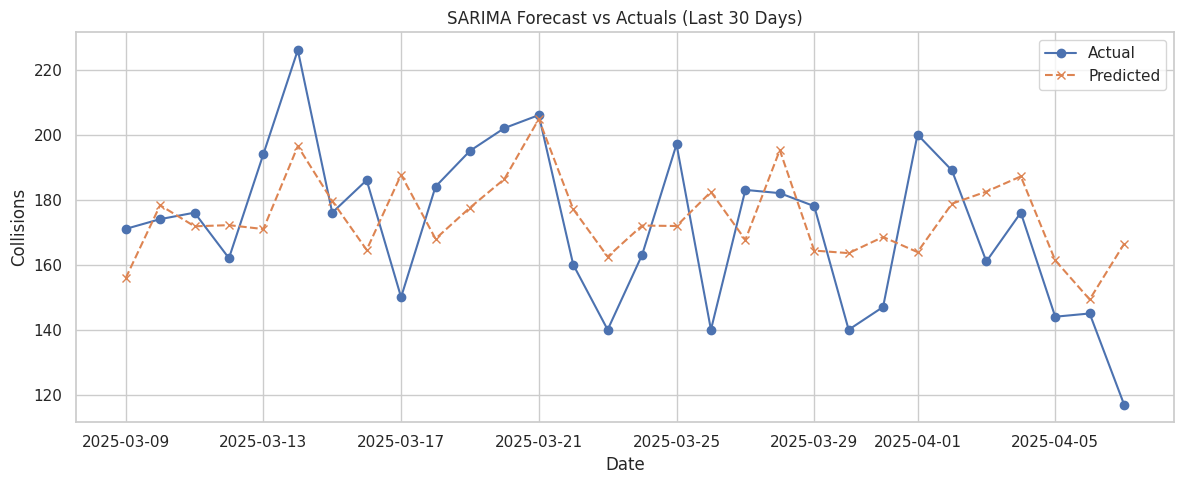

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(eval_df['ds'], eval_df['y'], label='Actual', marker='o')
plt.plot(eval_df['ds'], eval_df['yhat'], label='Predicted', linestyle='--', marker='x')
plt.title('SARIMA Forecast vs Actuals (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Collisions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
